In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import timedelta

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [2]:
plt.rcParams["figure.figsize"] = (15,10)

# Explore electricity demand forecasting for England and Wales

1. Import datasets
2. Data Preparation
3. Create Forecasts using FB Prophet

# Import datasets

In [3]:
# Import datasets, prepare and combine
df = pd.DataFrame()
datasets = os.listdir('./datasets')

path = os.getcwd()

print('datasets used :')
for dataset in datasets:
    print(dataset)
    df2 = pd.read_csv(path + '\\datasets\\' + dataset)
    df = pd.concat([df,df2], axis=0, ignore_index =True, sort=False)

datasets used :
DemandData_2017.csv
DemandData_2018.csv
DemandData_2019.csv
DemandData_2020.csv


# Data Preparation

In [4]:
# Convert settlement date and settlement period into datetime.
df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'], format='%d-%b-%Y')
#Push the data to the start of the settlement period. Avoids problems between days at midnight
df['minutes'] = (df['SETTLEMENT_PERIOD']*30)-30

df['hours'] = (df['minutes']/60).apply(np.floor).astype(int).astype(str)

df['hours'] = df['hours'].str.pad(2,side='left',fillchar='0')

df['mins_left'] = (df['minutes']%60).apply(np.floor).astype(int).astype(str)
df['mins_left'] = df['mins_left'].str.pad(2,side='right', fillchar ='0')

df['time'] = df['hours'] + ':' + df['mins_left']

df['SETTLEMENT_DATE'] = df['SETTLEMENT_DATE'].astype(str) + ' ' + df['time']

# We have a case where we more half hours than in the day - 29-10-2017
df = df[~df['SETTLEMENT_DATE'].str.contains('24:')]

df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'], format='%Y-%m-%d %H:%M')

In [5]:
# Create the correct format for use in prophet.

df_train = df[['SETTLEMENT_DATE','ENGLAND_WALES_DEMAND']]

df_train = df_train.rename(columns= {'SETTLEMENT_DATE':'ds','ENGLAND_WALES_DEMAND':'y'})

# Create Forecasts using FB Prophet

In [8]:
m = Prophet()

In [9]:
m.fit(df_train)

C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [10]:
forecast = m.predict(df_train)

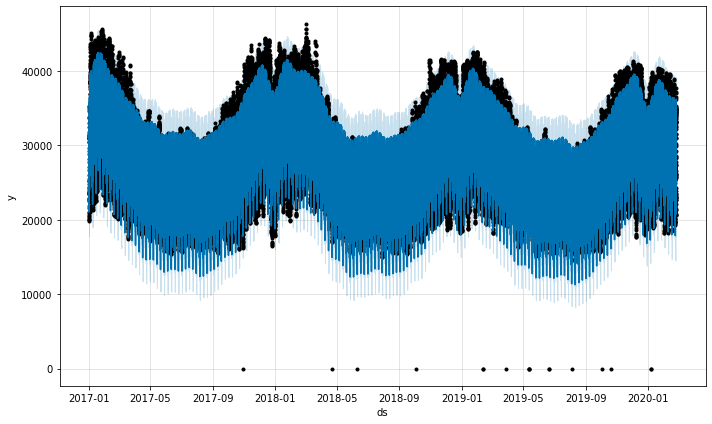

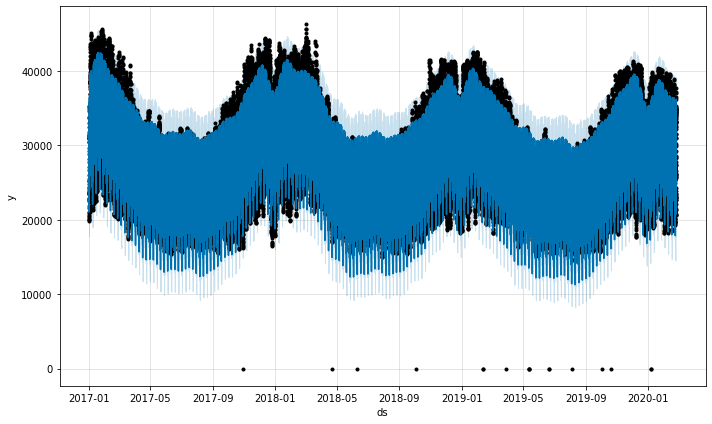

In [11]:
m.plot(forecast)

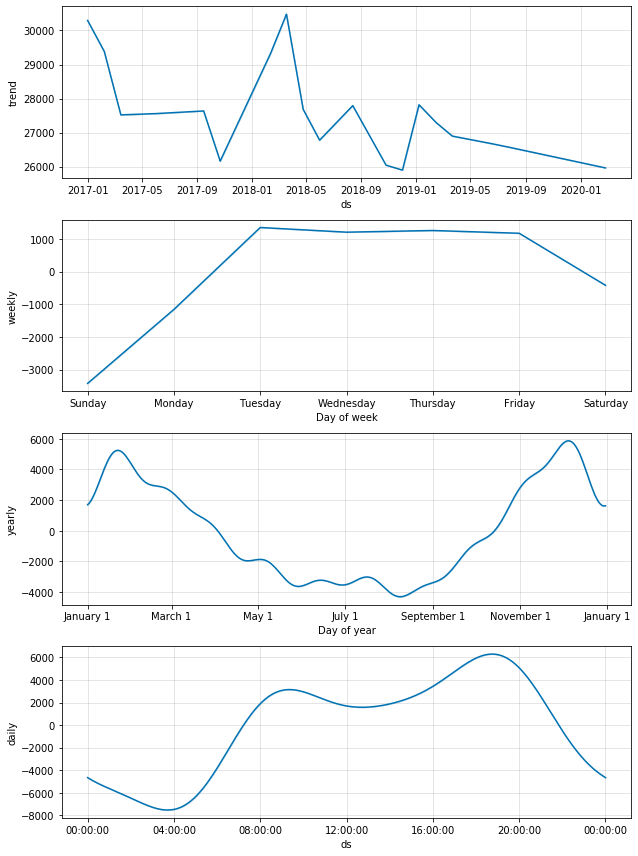

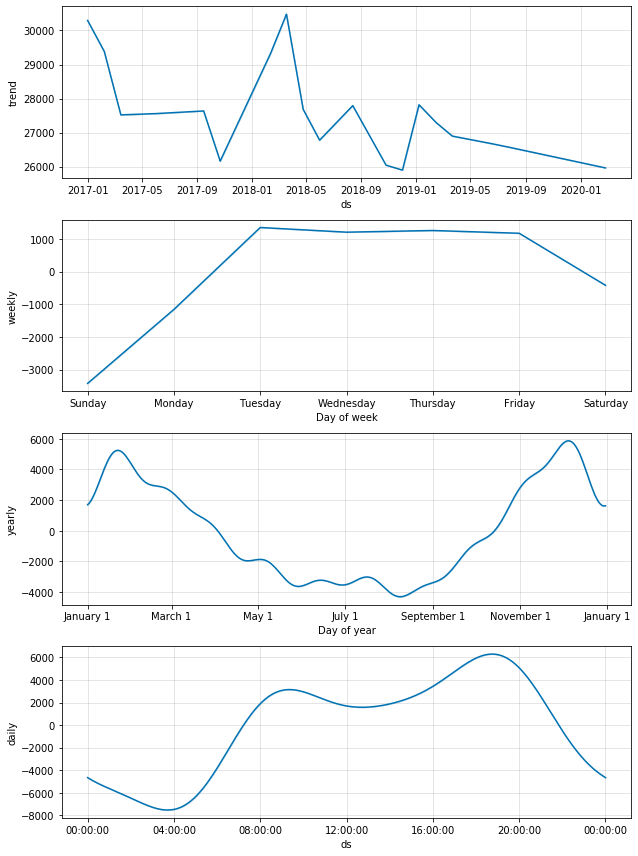

In [15]:
m.plot_components(forecast)


In [14]:
'''
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)
'''

'\nfrom fbprophet.plot import plot_plotly\nimport plotly.offline as py\npy.init_notebook_mode()\n\nfig = plot_plotly(m, forecast)  # This returns a plotly Figure\npy.iplot(fig)\n'

# How good is the Forecast?

In [17]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-02-24 23:30:00 and 2019-02-24 23:30:00
C:\Users\awalker8\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-02-25 00:00:00,23165.773488,20114.049151,26058.058661,22766,2019-02-24 23:30:00
1,2019-02-25 00:30:00,22718.274048,19659.433207,25563.804366,23173,2019-02-24 23:30:00
2,2019-02-25 01:00:00,22361.162913,19403.509580,25262.594502,23036,2019-02-24 23:30:00
3,2019-02-25 01:30:00,22024.111509,18914.207966,25033.567146,22583,2019-02-24 23:30:00
4,2019-02-25 02:00:00,21670.166757,18716.445093,24841.607035,22306,2019-02-24 23:30:00


In [21]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:30:00,8.620375e+06,2936.047529,2331.073294,0.073171,0.681896
1,36 days 13:00:00,8.645056e+06,2940.247657,2334.606314,0.073299,0.681325
2,36 days 13:30:00,8.665118e+06,2943.657255,2337.741431,0.073343,0.680754
3,36 days 14:00:00,8.680082e+06,2946.197808,2340.304625,0.073355,0.680183
4,36 days 14:30:00,8.692446e+06,2948.295399,2342.661844,0.073440,0.679612


# Exploring prophet options

1. Saturating max and min - do we have a min or max in this case?
2. Adding trend changepoints - suggest the most likely places of a significant change point or specify them yourselves.
3. Seasonality and holidays 
4. Additional regressors